In [61]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
K = 10
TRIALS = 1000
ITERATIONS = 20
MEAN_MEAN = 0
MEAN_STDDEV = 1
SAMPLE_STDDEV = 1
MEANS = np.random.normal(MEAN_MEAN, MEAN_STDDEV, K)
DATA = np.array([np.random.normal(mu, SAMPLE_STDDEV, (TRIALS, ITERATIONS)) for mu in MEANS])
EPSILON = 0.1

In [63]:
print(DATA.shape)
print(MEANS)
print(np.mean(DATA, axis=1))

(10, 1000, 20)
[ 0.33258517  0.32101173  0.66819717 -2.00132594  0.43583436  0.86400052
  1.06991127  0.70230734 -0.3057276  -0.40550389]
[[ 0.30675003  0.35544533  0.31698498  0.31283277  0.33954462  0.31657503
   0.32376697  0.35541728  0.39863626  0.38382317  0.34681602  0.34091276
   0.36319981  0.33911342  0.35073535  0.35437236  0.37110852  0.30358727
   0.33014195  0.38228427]
 [ 0.30707609  0.36540539  0.29102623  0.28845005  0.31323718  0.31872692
   0.25968401  0.29494154  0.29866201  0.29332419  0.33959168  0.32429473
   0.30417158  0.29922193  0.32645549  0.31359045  0.31451366  0.40294569
   0.31577336  0.29602889]
 [ 0.67482993  0.66672747  0.71351277  0.69032018  0.68128408  0.7188327
   0.68049263  0.66807648  0.64741568  0.66946708  0.67754616  0.6364233
   0.64396226  0.66951917  0.66069465  0.68401225  0.65907718  0.69281702
   0.67460502  0.65727822]
 [-2.01697111 -2.03662091 -1.97173482 -2.01667568 -1.98143608 -1.9923114
  -1.9632462  -2.07872934 -2.05418327 -1.988

In [67]:
class Env:
    def __init__(self, data, true_means):
        self.data = data
        self.true_means = true_means

class Bandit:
    def __init__(self, k, env, epsilon=None, ucb=None, gradient=None, q_0=0, step=0, iter=0):
        self.k = k
        self.env = env
        self.epsilon = epsilon
        self.ucb = ucb
        self.gradient = gradient
        self.steps = self.env.data.shape[1]
        self.iters = self.env.data.shape[2]
        self.counts = np.zeros(k)
        self.q_0 = q_0
        self.q = np.full(self.k, self.q_0, dtype=float)
        self.avg = np.zeros(self.steps, dtype=float)
        self.opt = np.zeros(self.steps, dtype=float)
        self.step = step
        self.iter = iter

    def select(self):
        if self.epsilon is not None:
            x = np.random.random()
            if x > self.epsilon:
                return np.argmax(self.q)
            else:
                return np.random.randint(0, self.k)

        if self.ucb:
            return np.argmax(self.q + self.ucb*np.sqrt(np.log(1 + self.step) / (self.counts + 1e-5)))
        
        if self.gradient:
            p = np.exp(self.q)/np.sum(np.exp(self.q))
            return np.random.choice(np.arange(self.k), p)
        
    def act(self):
        index = self.select()
        reward = self.env.data[index, self.step, self.iter]
        n = self.counts[index]
        mean = self.q[index]
        if self.step == 0:
            self.avg[0] = reward
            self.opt[0] = int(index == np.argmax(self.env.true_means))
        else:
            self.avg[self.step] = (self.step * self.opt[self.step-1] + reward) / (self.step + 1)
            self.opt[self.step] = (self.step * self.opt[self.step-1] + int(index == np.argmax(self.env.true_means))) / (self.step + 1)
        
        if self.epsilon is not None or self.ucb:
            self.q[index] = (n * mean + reward) / (n+1)

        else: # gradient
            id = np.zeros(self.k)
            id[index] = 1
            self.q[index]
            self.q += self.gradient * (reward - self.avg[self.step]) * (id - np.exp(self.q)/np.sum(np.exp(self.q)))

        self.counts[index] += 1
        self.step += 1
        
    def reset(self):
        self.counts = np.zeros(self.k)
        self.q = np.full(self.k, self.q_0, dtype=float)
        self.avg = np.zeros(self.steps)
        self.opt = np.zeros(self.steps)
        self.step = 0
        self.iter += 1
        
    def run(self):
        avg = np.zeros((self.iters, self.steps))
        opt = np.zeros((self.iters, self.steps))
        for i in range(self.iters):
            for j in range(self.steps):
                self.act()
                avg[i, j] = self.avg[j]
                opt[i, j] = self.opt[j]
            print(self.q)
            self.reset()
        avg = np.mean(avg, axis=0)
        opt = np.mean(opt, axis=0)
        return avg, opt

[ 0.33258517  0.32101173  0.66819717 -2.00132594  0.43583436  0.86400052
  1.06991127  0.70230734 -0.3057276  -0.40550389]
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
h

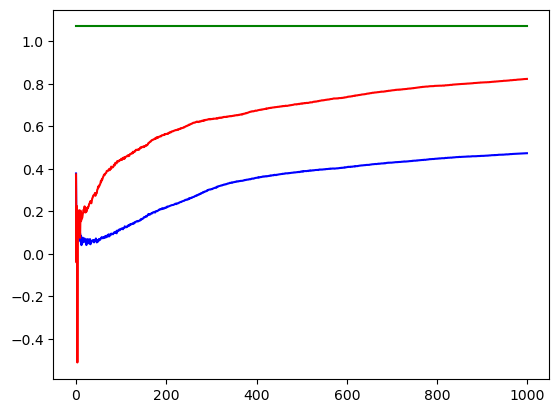

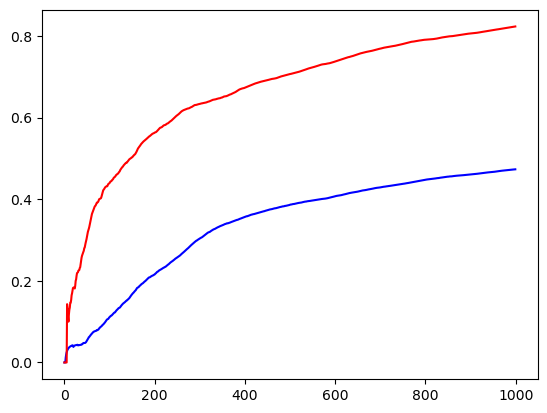

In [68]:
print(MEANS)
env = Env(DATA, MEANS)
bandit1 = Bandit(K, env, epsilon=EPSILON)
avg1, opt1 = bandit1.run()
plt.plot(avg1, color='blue')

bandit2 = Bandit(K, env, ucb=1)
avg2, opt2 = bandit2.run()
plt.plot(avg2, color='red')
plt.plot(np.full(TRIALS, np.max(MEANS)), color='green')
plt.show()

plt.plot(opt1, color='blue')
plt.plot(opt2, color='red')
plt.show()

In [66]:
print(MEANS)

[ 0.33258517  0.32101173  0.66819717 -2.00132594  0.43583436  0.86400052
  1.06991127  0.70230734 -0.3057276  -0.40550389]
